In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.options.display.max_rows = 999
import geopandas as gpd

# df = pd.read_csv('sintetico_circus_income_YQ'+T+'.csv')
df = pd.read_csv('./data/sintetico_circus_income_YQ_deflac.csv', usecols = ['RADIO_REF_ID', 'V01', 'DPTO', 'circuito', 'H05', 'H06', 'H07', 'H08',
       'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'PROP',
       'IX_TOT', 'AGLOMERADO', 'PERSONA_REF_ID', 'P02', 'P03', 'P05', 'P07',
       'P08', 'P09', 'P10', 'CONDACT', 'dpto_merge', 'CAT_OCUP', 'CAT_INAC',
       'CH07', 'P47T'])

df['P47T'] = df['P47T']*1420 # precios de Sep 2018

df['circuito'] = df['circuito'].astype(str).str.zfill(5)#.astype(str) # Aparente bug por el cual los str quedan como numeros y depues no matchea el circuito


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
df.columns

Index(['RADIO_REF_ID', 'V01', 'DPTO', 'circuito', 'H05', 'H06', 'H07', 'H08',
       'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'PROP',
       'IX_TOT', 'AGLOMERADO', 'PERSONA_REF_ID', 'P02', 'P03', 'P05', 'P07',
       'P08', 'P09', 'P10', 'CONDACT', 'dpto_merge', 'CAT_OCUP', 'CAT_INAC',
       'CH07', 'P47T'],
      dtype='object')

### Lo mas facil seria modificar df, de forma que los dptos pasen a llamarse por su seccion y sus circuitos pasen a llamarse por el partido. 

In [3]:
# Acomodamos los dptos segun cantidad de electores, creamos los df de referencia con estas nuevas areas

secciones = pd.read_csv('./data/secciones.csv')

ordered = df.groupby('dpto_merge')['PERSONA_REF_ID'].count().sort_values(ascending = False).reset_index()

n_partidos = 65

dptos_agrupados = ordered.iloc[n_partidos:].merge(secciones)[['label', 'dpto_merge']]
dptos_agrupados['area_0'] = dptos_agrupados['label']; dptos_agrupados = dptos_agrupados.drop('label', 1)
dptos_agrupados['area_1'] = dptos_agrupados['dpto_merge']

dptos_sueltos = ordered.iloc[:n_partidos].merge(df[['dpto_merge', 'circuito']].drop_duplicates())[['dpto_merge', 'circuito']]
dptos_sueltos['area_0'] = dptos_sueltos['dpto_merge']
dptos_sueltos['area_1'] = dptos_sueltos['circuito']

ordered['grouped'] = (ordered.index >= n_partidos).astype(int)
ordered = ordered.drop('PERSONA_REF_ID', 1)

In [4]:
# Se lo ponemos al df. Tenemos el result

df = df.merge(ordered)

df_suelto = df.loc[df.grouped == 0].merge(dptos_sueltos)
df_agrup = df.loc[df.grouped == 1].merge(dptos_agrupados)

df_final = pd.concat([df_suelto, df_agrup])


## Primero lo primero. El total de electores por lugar

In [5]:
df_final.shape
# sampleo randomizado de un numero igual al 10% de los electores (1.527.885). No hace falta cargar 15 millones de personas, mas liviano multiplicar el numero al final. 
# La precision es de +- 10

(1524749, 36)

In [6]:
# area_0 / area_1 representan Partido/circuito o bien zona_gde/partidos (cuando los partidos son chicos se agrupan)
electoresxlugar = 10*df_final.groupby(['area_0','area_1']).count().rename(columns = {'PERSONA_REF_ID': 'n_electores'})[['n_electores']]
electoresxlugar.to_csv('./data/n_electores.csv')
electoresxlugar.sort_values(by = 'n_electores', ascending = False).head(20).sort_index()

n_electores
area_0             area_1             
almirante brown    00019         96650
florencio varela   00302        117520
general pueyrredon 00364        135510
                   00365        119500
                   00366         88460
                   00367         72540
general rodriguez  00374         75290
jose c. paz        00398         83820
                   0398A         75170
la matanza         00635        115900
                   0635A        104590
                   0635B        103040
lomas de zamora    00583        206750
                   00587         94740
merlo              0652A        139020
moreno             0663C         83960
moron              00665        104920
pilar              00768         77400
tandil             00933        104120
tres de febrero    00391         82800

In [7]:
result_comb = df_final.groupby(['area_0', 'area_1'])['P47T'].describe()

#Refinado
result_comb = result_comb.round(-1).clip(0)[['25%', '50%', '75%', 'count']].rename(columns = {'count': 'electores', '50%':'mediana'}).astype(int)
name_l0 = 'Ingresos (basado en EPH)'
result_comb = pd.concat([result_comb], axis=1, keys=[name_l0])
result_comb[(name_l0, 'electores')] = result_comb[(name_l0, 'electores')]*10

result_comb.to_csv('./data/result_comb_circ.csv')

In [8]:
result_comb = 10*df_final.groupby(['area_0', 'CONDACT', 'CAT_OCUP', 'CAT_INAC'])[['PERSONA_REF_ID']].count()
# dg.sort_values(by = 'PERSONA_REF_ID',ascending = False).cumsum().iloc[400:].diff()#/15278850.
dg = result_comb
dg.index.set_levels(['', 'Jubilado', 'Rentista', 'Estudiante', 'Ama de casa', 'Menor', 'Discapacitado', 'Otros'], level = 'CAT_INAC', inplace = True)
dg.index.set_levels(['', 'Patron', 'Cta Propia', 'Obrero', 'Familiar', 'Otros'], level = 'CAT_OCUP', inplace = True)
dg.index.set_levels(['OCUPADO', 'DESOCUP', 'INACTIVO'], level = 'CONDACT', inplace = True)
table = dg.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).loc[result_comb.PERSONA_REF_ID > 1000].unstack(0)['PERSONA_REF_ID'].T

table.to_csv('./data/cat_ocups.csv')

In [9]:
# Hacemos lo mismo con el de votos

In [10]:
votos = pd.read_csv('./../../Documents/EleccionesARG/data/tablas_votos/VOTOS_2015_17_circ_cnt.csv', index_col=[0, 1, 2], header = [0, 1])
votos.index = votos.index.droplevel(-1)
ordered_mi = pd.concat([ordered.set_index('dpto_merge')], axis=1, keys=['key'])
pd.concat([votos, ordered_mi], axis = 1)

votos_ = pd.concat([votos], axis=1, keys=['VOTOS'])
votos_
votos_list = votos_.stack(-2, -1).stack().reset_index()
votos_list = votos_list.merge(ordered, left_on = ['dpto_merger_str'], right_on = ['dpto_merge'])
votos_list['circuito'] = votos_list['circuito'].str.zfill(5)

votos_list_suelto = votos_list.loc[votos_list.grouped == 0].merge(dptos_sueltos, how = 'left')
votos_list_suelto['area_0'] = votos_list_suelto['dpto_merge']; votos_list_suelto['area_1'] = votos_list_suelto['circuito'] # parche porque algunos circuitos se pierden en el merge

votos_list_agrup = votos_list.loc[votos_list.grouped == 1].merge(dptos_agrupados, how = 'left')

votos_list_comb = pd.concat([votos_list_suelto, votos_list_agrup])

# #Listo, ahora lo vamos a agrupar y darle la forma del dataset de votos original

votos_comb = votos_list_comb.groupby(['area_0', 'area_1', 'level_2', 'level_3'])[['VOTOS']].sum()

votos_comb = votos_comb.unstack(-2, -1).unstack()['VOTOS'].reindex(votos.columns, axis = 1)

In [11]:
votos_comb.to_csv('./data/votos_comb.csv')

In [12]:
# Votos los quiero en pct y por area

votos_area = votos_comb.groupby(level = 0).sum()
r_list = []
for eleccion in ['DN_2015', 'paso_2017', 'DN_2017']:
    votos_area_eleccion = votos_area.T.loc[votos_area.columns.get_level_values(1) == eleccion].T
    votos_area_eleccion_pct = 100*votos_area_eleccion.div(votos_area_eleccion.iloc[:, 1], 0)
    r_list += [votos_area_eleccion_pct]
    
votos_area_pct = pd.concat(r_list,1)
votos_area_pct = votos_area_pct.reindex(votos.columns, axis = 1)
votos_area_pct.to_csv('./data/votos_area_pct.csv')

# Combine GeoDataFrames

In [13]:
gdf = gpd.read_file('./../EleccionesARG/data/circuitos/clean/clean.shp')
gdf['circuito'] = gdf['circuito'].str.zfill(5)
# print(len(gdf))
gdf = gdf.merge(ordered)
# print(len(gdf))

gdf_suelto = gdf.loc[gdf.grouped == 0].merge(dptos_sueltos, how = 'left')
gdf_suelto['area_0'] = gdf_suelto['dpto_merge']; gdf_suelto['area_1'] = gdf_suelto['circuito'] # parche porque algunos circuitos se pierden en el merge
gdf_agrup = gdf.loc[gdf.grouped == 1].merge(dptos_agrupados)

gdf_suelto = gdf_suelto.dissolve(by = ['area_0', 'area_1'])[['PROV_REF_I','provincia','dpto_merge','geometry']]
gdf_agrup = gdf_agrup.dissolve(by = ['area_0', 'area_1'])[['PROV_REF_I','provincia','dpto_merge','geometry']]
# print(len(gdf_suelto) + len(gdf_agrup))

gdf = gpd.GeoDataFrame(pd.concat([gdf_suelto, gdf_agrup]).reset_index())
gdf.to_file('./../EleccionesARG/data/circuitos/custom/BA_custom_areas.shp')

# Listo

### Combine result, nivel dptos, resto seccion

In [14]:
# sorted_ = votos_comb.iloc[:, 2].sort_values(ascending = False)
# orden = (100 * sorted_.cumsum()/sorted_.sum()).round(1)
# orden.head()

In [15]:
# import numpy as np
# import seaborn as sns
# cm = sns.light_palette("green", as_cmap=True)
# s = result.copy()
# s = np.round(result_dpto[['count','25%','50%','75%']], -1).sort_values(by = '50%')
# s.style.background_gradient(cmap=cm)


## Salario medio por circuito

In [16]:
# import geopandas as gpd

# circuito_shp = gpd.read_file('./../EleccionesARG/data/circuitos/clean/clean.shp')
# circuito_shp['circuito'] = circuito_shp['circuito'].str.zfill(5)
# circuito_shp = circuito_shp.dissolve(by = ['dpto_merge','circuito'])

# quantile = '50%'
# income = result[[quantile]]
# income
# # income.index = income.index.droplevel([0, 3, 4])
# # income.index = income.index.droplevel([0])

# gdf = gpd.GeoDataFrame(pd.concat([income, circuito_shp], axis = 1))

In [17]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.figure(figsize=(8, 10))

# fig, axs = plt.subplots(1, 2, figsize = (15, 12))
# # lst = list(activity)
# # lst[0] = 'RCA'
# # activity = tuple(lst)

# for i in range(2):
#     ax = axs[i]
#     gdf.plot(column = quantile, vmin = 8000, vmax = 16000, cmap = 'RdYlGn', linewidth = 0, ax = ax)

#     if i == 0: ax.set(xlim = (-64, -56), ylim = (-41.4, -33))#; ax.set_title(str(activity)+'\nProvincia Buenos Aires')
#     if i == 1: ax.set(xlim = (-59.0, -57.9), ylim = (-35.2, -33.9))#; ax.set_title(str(activity)+'\nGran Buenos Aires')

#     ax.axis('off')
# plt.show()

## Salario medio vs votos

In [18]:
## Traer data de ingresos

In [19]:
result_comb = pd.read_csv('./data/result_comb_circ.csv', header = [0, 1], index_col = [0, 1])
data = result_comb#.reset_index()
data = data.loc[(data.iloc[:, -1] > 20000)]#.drop(['CONDACT', 'CAT_INAC'], axis = 1)

In [20]:

votos = pd.read_csv('./../../Documents/EleccionesARG/data/tablas_votos/VOTOS_2015_17_circ_pct.csv', index_col=[0, 1, 2], header = [0])

# Toda esta vuelta es para ponerle nombres familiares a las listas. Pandas no deja setear nombres repetidos en nivel de multiindex
votos.columns = ['ELECTORES', 'ELECTORES', 'ELECTORES', 'VOTANTES', 'VOTANTES',
       'VOTANTES', 'CAMBIEMOS', 'CAMBIEMOS', 'CAMBIEMOS', 'FPV / UC', 'FPV / UC', 'FPV / UC', 'Massa', 'Massa', 'Massa', 'BLANCOS', 'BLANCOS', 'BLANCOS',
       'FJ (Randazzo)', 'FJ (Randazzo)', 'FIT', 'FIT', 'FIT']
cols = list(zip(votos.columns, votos.iloc[0,:]))
c1 = pd.MultiIndex.from_tuples(cols, names=['Fuerza', 'Eleccion'])
votos = pd.DataFrame(data=votos[2:].values, columns=c1, index=votos.index[2:])
for col in votos.columns:
    votos[col] = pd.to_numeric(votos[col])
votos.index = votos.index.droplevel(-1)
votos.index.names = ['area_0', 'area_1']
votos.head()

Fuerza               ELECTORES                   VOTANTES                    \
Eleccion               DN_2015 paso_2017 DN_2017  DN_2015 paso_2017 DN_2017   
area_0        area_1                                                          
adolfo alsina 0001      124.75    133.20  129.81    100.0     100.0   100.0   
              0002      158.93    196.43  183.33    100.0     100.0   100.0   
              0003      124.58    145.17  125.64    100.0     100.0   100.0   
              0004      192.86    227.78  227.78    100.0     100.0   100.0   
              0005      123.22    133.02  133.57    100.0     100.0   100.0   

Fuerza               CAMBIEMOS                   FPV / UC   ...       Massa  \
Eleccion               DN_2015 paso_2017 DN_2017  DN_2015   ...   paso_2017   
area_0        area_1                                        ...               
adolfo alsina 0001       44.64     47.05   51.71    26.78   ...       10.63   
              0002       50.00     67.86   76.67    10.71   ...       10.71   
              0003       43.64     56.41   58.26    26.88   ...       14.55   
              0004       57.14     66.67   66.67    21.43   ...       27.78   
              0005       64.29     62.74   71.89    17.65   ...        9.67   

Fuerza                       BLANCOS                   FJ (Randazzo)          \
Eleccion             DN_2017 DN_2015 paso_2017 DN_2017     paso_2017 DN_2017   
area_0        area_1                                                           
adolfo alsina 0001      9.87   13.40      7.71    7.20          7.57    6.49   
              0002     10.00   12.50      3.57    0.00          7.14    6.67   
              0003     10.82   11.73      6.62    3.59          7.60    4.28   
              0004     33.33    7.14      5.56    0.00          0.00    0.00   
              0005      7.83    7.02      7.08    3.32          2.59    2.61   

Fuerza                     FIT                  
Eleccion             paso_2017 DN_2017 DN_2015  
area_0        area_1                            
adolfo alsina 0001        1.16    2.20    1.22  
              0002        3.57    0.00    1.79  
              0003        1.40    1.86    1.35  
              0004        0.00    0.00    0.00  
              0005        0.59    0.95    0.72  

[5 rows x 23 columns]

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import numpy as np

[(0, 65),
 Text(0, 0.5, 'PORCENTAJE VOTOS'),
 Text(0.5, 0, 'INGRESO MEDIANO (pesos corr Sep-18)')]

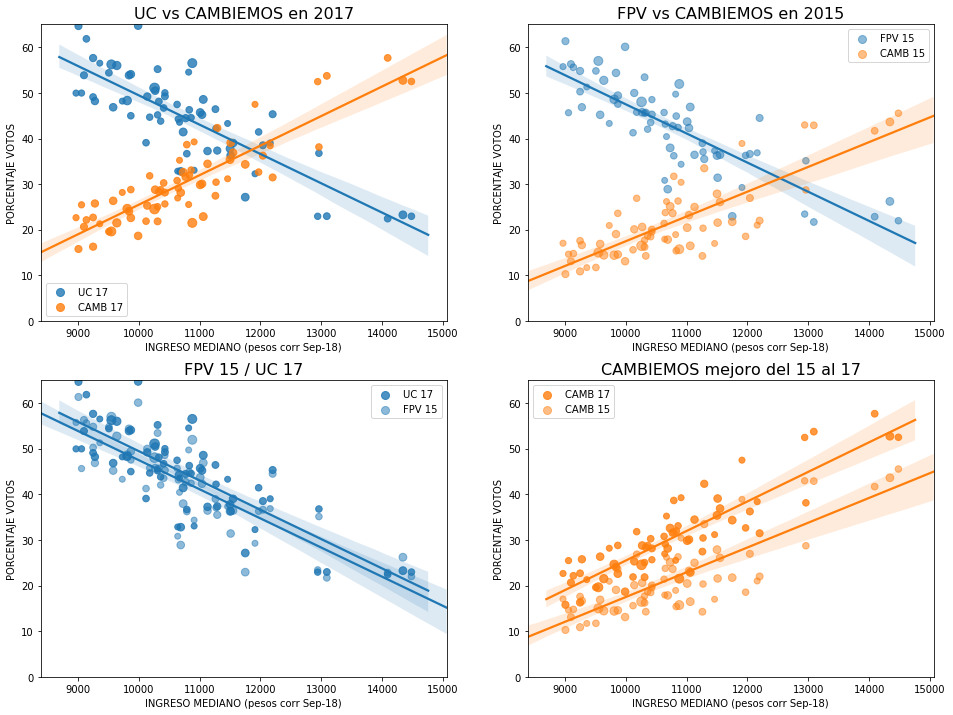

In [22]:
pd.options.display.max_columns = 99

quantile = 'mediana'

###

d = pd.concat([data, votos], axis = 1).dropna().reset_index(drop = True)
# d = d[[( 'Ingresos', 'electores'),(quantile, 'Ingresos'), ('UNIDAD CIUDADANA', 'DN_2017'), ('CAMBIEMOS', 'DN_2017'), ('ALIANZA FRENTE PARA LA VICTORIA', 'DN_2015'), ('CAMBIEMOS', 'DN_2015')]]
d.columns = d.columns.map('_'.join)
d['size'] = np.sqrt(d['Ingresos (basado en EPH)_electores'])

###
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

ax = axs[0, 0]
plot_UC17 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y = 'FPV / UC_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .8,'s': d['size']}, color = '#1f77b4', label = 'UC 17')
plot_PRO17 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='CAMBIEMOS_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .8, 's': d['size']}, color = '#ff7f0e', label = 'CAMB 17')
ax.legend()
ax.set_title('UC vs CAMBIEMOS en 2017', fontsize = 16)
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 65))


###
ax = axs[0, 1]
plot_UC15 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FPV / UC_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .5, 's': d['size']}, color = '#1f77b4', label = 'FPV 15')
plot_PRO15 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='CAMBIEMOS_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .5, 's': d['size']}, color = '#ff7f0e', label = 'CAMB 15')
ax.legend()
ax.set_title('FPV vs CAMBIEMOS en 2015', fontsize = 16)
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 65))


###
ax = axs[1, 0]
plot_UC17 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FPV / UC_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .8, 's': d['size']}, color = '#1f77b4', label = 'UC 17')
plot_UC15 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FPV / UC_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .5, 's': d['size']}, color = '#1f77b4', label = 'FPV 15')
ax.legend()
ax.set_title('FPV 15 / UC 17', fontsize = 16)
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 65))


###
ax = axs[1, 1]
plot_PRO17 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='CAMBIEMOS_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .8,'s': d['size']}, color = '#ff7f0e', label = 'CAMB 17')
plot_PRO15 = sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='CAMBIEMOS_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .5, 's': d['size']}, color = '#ff7f0e', label = 'CAMB 15')
ax.legend()
ax.set_title('CAMBIEMOS mejoro del 15 al 17', fontsize = 16)
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 65))


[(0, 60),
 Text(0, 0.5, 'PORCENTAJE VOTOS'),
 Text(0.5, 0, 'INGRESO MEDIANO (pesos corr Sep-18)')]

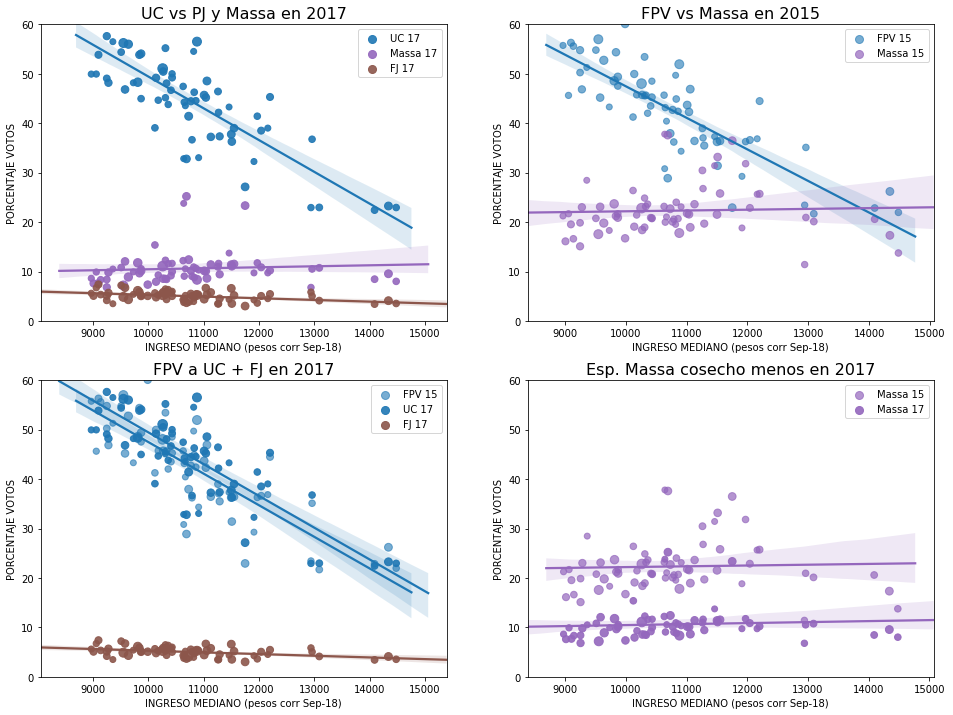

In [23]:
pd.options.display.max_columns = 99

quantile = 'mediana'

###

d = pd.concat([data, votos], axis = 1).dropna().reset_index(drop = True)
# d = d[[('count', 'Ingresos'),(quantile, 'Ingresos'), ('FPV / UC', 'DN_2017'), ('Massa', 'DN_2017'), ('FPV / UC', 'DN_2015'), ('Massa', 'DN_2015')]]
d.columns = d.columns.map('_'.join)
d['size'] = np.sqrt(d['Ingresos (basado en EPH)_electores'])

###

fig, axs = plt.subplots(2, 2, figsize = (16, 12))

# d['Massa_DN_2017'] = d['Massa_DN_2017']*4
# d['FJ (Randazzo)_DN_2017'] = d['FJ (Randazzo)_DN_2017']*6

ax = axs[0, 0]
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y = 'FPV / UC_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .9,'s': d['size']}, label = 'UC 17')
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='Massa_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .9,'s': d['size']}, color = '#9467bd', label = 'Massa 17')
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FJ (Randazzo)_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .9,'s': d['size']}, color = '#8c564b', label = 'FJ 17')
ax.set_title('UC vs PJ y Massa en 2017', fontsize = 16)
ax.legend()
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 60))


###

ax = axs[0, 1]
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FPV / UC_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .6, 's': d['size']}, color = '#1f77b4', label = 'FPV 15')
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='Massa_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .7, 's': d['size']}, color = '#9467bd', label = 'Massa 15')
ax.set_title('FPV vs Massa en 2015', fontsize = 16)
ax.legend()
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 60))


###

ax = axs[1, 0]
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FPV / UC_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .6, 's': d['size']}, color = '#1f77b4', label = 'FPV 15')
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FPV / UC_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .9,'s': d['size']}, color = '#1f77b4', label = 'UC 17')
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='FJ (Randazzo)_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .9,'s': d['size']}, color = '#8c564b', label = 'FJ 17')
ax.set_title('FPV a UC + FJ en 2017', fontsize = 16)
ax.legend()
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 60))

###

ax = axs[1, 1]
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='Massa_DN_2015', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .7, 's': d['size']}, color = '#9467bd', label = 'Massa 15')
sns.regplot(x= 'Ingresos (basado en EPH)_'+quantile, y='Massa_DN_2017', data = d, marker = '.', ax = ax, scatter_kws = {'alpha': .9,'s': d['size']}, color = '#9467bd', label = 'Massa 17')
ax.set_title('Esp. Massa cosecho menos en 2017', fontsize = 16)
ax.legend()
ax.set(xlabel = 'INGRESO MEDIANO (pesos corr Sep-18)', ylabel = 'PORCENTAJE VOTOS', ylim = (0, 60))
